In [222]:
import numpy as np
import pdr
from method.download_method import download_with_requests
from pathlib import Path
from tqdm import tqdm
import os

# PRODUCT_ID = "S_00168901"
PRODUCT_ID = "S_00170101"
# PRODUCT_ID = "S_00170601"
PRODUCT_ID_PREFIX = PRODUCT_ID[:6] + "XX"
url_prefix = "https://pds-geosciences.wustl.edu/mro/mro-m-sharad-5-radargram-v2/mrosh_2101/"
geom_lbl_url = url_prefix + "DATA/GEOM/" + PRODUCT_ID_PREFIX + "/" + PRODUCT_ID + "_GEOM.LBL"
geom_table_url = url_prefix + "DATA/GEOM/" + PRODUCT_ID_PREFIX + "/" + PRODUCT_ID + "_GEOM.TAB"
rdr_lbl_url = url_prefix + "DATA/RGRAM/" + PRODUCT_ID_PREFIX + "/" + PRODUCT_ID + "_RGRAM.LBL"
rdr_img_url = url_prefix + "DATA/RGRAM/" + PRODUCT_ID_PREFIX + "/" + PRODUCT_ID + "_RGRAM.IMG"
save_path = r"E:\PycharmProjects\mars_sim_web\method\sharad_sim\data\RDR\rdr_data"
urls = [geom_lbl_url, geom_table_url, rdr_lbl_url, rdr_img_url]
filenames = [Path(url).name for url in urls]
download_with_requests(urls, filenames, save_path, overwrite=False)

所有文件已经存在。


In [223]:
# 读取GEOM
geom = pdr.read(os.path.join(save_path, filenames[0]))
geom = geom["TABLE"]
# 调整LONGITUDE的值，使其从0-360变为-180到180之间
geom.loc[geom["LONGITUDE"] > 180, "LONGITUDE"] -= 360
# 读取RGRAM
rgram = pdr.read(os.path.join(save_path, filenames[2]))
rgram = rgram["IMAGE"]

In [224]:
from method.sharad_sim.simmulation import *

sim_area_lonlat, sat_lon_lat, point_count, sat_radius = get_sim_area_lonlat(
    geom
)
sim_area_cartesian = get_sim_area_cartesian(sim_area_lonlat, point_count)
facet_index = cal_facet_idx()
center_point = cal_center_point(sim_area_cartesian, facet_index, point_count)
normal_vector, area = cal_normal_vector_and_area(
            geom, sim_area_cartesian, facet_index, sat_lon_lat
        )
incident_angle, delay, distance = get_incidence_angle_and_delay(
            sat_lon_lat, center_point, normal_vector, sat_radius
        )
delay_index = cal_delay_index(delay)

插值仿真区域的DEM: 100%|██████████| 1928/1928 [00:31<00:00, 60.88it/s]


In [225]:
# 星下点是sim_area_cartesian的[:,1500,1,:]，即第1500列的点
sub_star_point = sim_area_cartesian[:, 1500, 1, :]
sat_pos = lonlat_to_cartesian(sat_lon_lat, sat_radius).T
incident_vector = sub_star_point - sat_pos
_distance = np.linalg.norm(incident_vector, axis=1)
relative_height = np.linalg.norm(sat_pos, axis=1)
sub_star_point_delay = 2 * (_distance - relative_height + mars_radius) / velocity_light
# delay_axis是一个以delay_interval为间隔的等差数列，长度为3600，第1800个元素为0
delay_axis = np.linspace(-delay_interval * 1799, delay_interval * 1800, 3600)
delay_axis_min = delay_axis.min()
# delay-时延的最小值，再除以时延间隔，得到时延的索引
sub_star_point_delay_index = (sub_star_point_delay - delay_axis_min) / delay_interval
# 取整
sub_star_point_delay_index = np.int32(np.round(sub_star_point_delay_index))
sub_star_point_delay_index

array([1836, 1836, 1835, ..., 1564, 1564, 1564])

In [226]:
delay_index.shape

(1928, 12000)

In [227]:
area.shape

(1928, 12000)

In [228]:
rgram.shape

(3600, 1928)

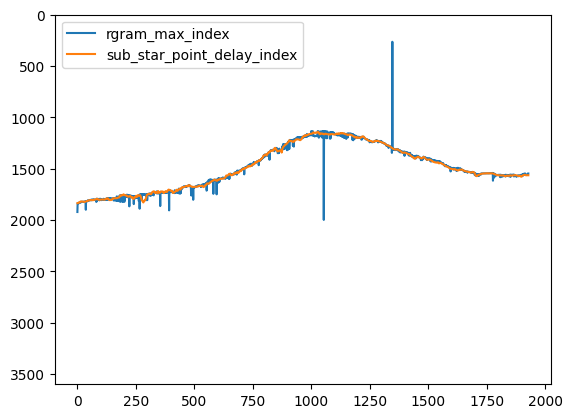

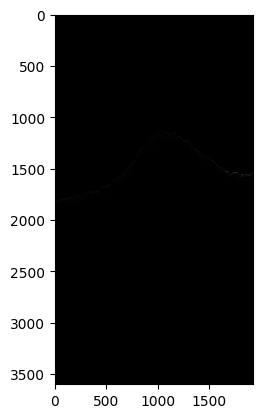

In [230]:
# rgram画图
plt.imshow(rgram,cmap="gray")
# 保存高清图
plt.savefig("rgram.png",dpi=300)

(1928,)


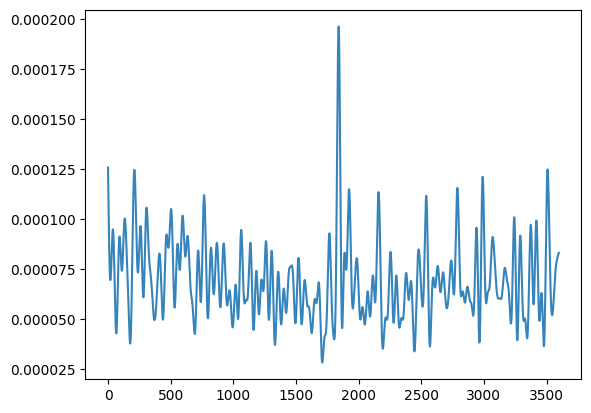

In [270]:
# 过采样系数
oversampling_factor = 1
# 对rgram在axis = 0上进行过采样，即每个点重复3次
rgram_reshape = np.repeat(rgram, oversampling_factor, axis=0)
# 对rgram_reshape在axis = 0上进行低通滤波
import scipy.signal as signal
b, a = signal.butter(8, 0.05, "lowpass")
rgram_reshape = signal.filtfilt(b, a, rgram_reshape, axis=0)
# 对rgram_reshape在axis = 0上进行下采样
rgram_reshape = rgram_reshape[::oversampling_factor, :]
# 取出rgram_reshape的axis=0的每一列的sub_star_point_delay_index[i]位置的前面和后面10个数据
rgram_power = np.zeros((21, rgram_reshape.shape[1]))
for i in range(rgram_reshape.shape[1]):
    rgram_power[:, i] = rgram_reshape[sub_star_point_delay_index[i] - 10 : sub_star_point_delay_index[i] + 11, i]
rgram_power_max = rgram_power[10, :]
print(rgram_power_max.shape)
# 对rgram_power_max进行最小二乘二次拟合,并画出拟合曲线
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * x ** 2 + b * x + c
popt, pcov = curve_fit(func, np.arange(rgram_power.shape[1]), rgram_power_max)
# plt.plot(func(np.arange(rgram_power.shape[1]), *popt))
# 画出axis = 0 的第10个点
plt.plot(rgram_reshape[:, 2],alpha=0.9)
# plt.plot(rgram[:, 312],alpha=0.5)

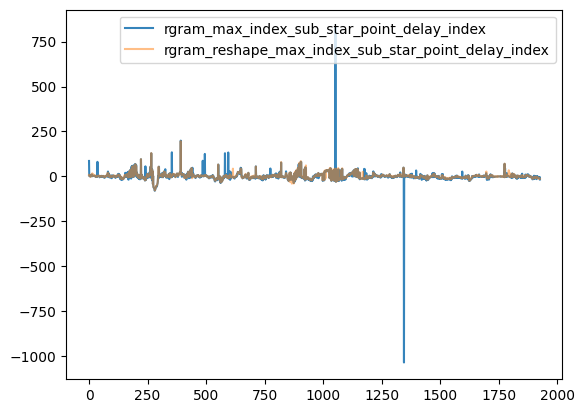

In [275]:
import pandas as pd
# rgram最大值的索引
rgram_max_index = np.argmax(rgram, axis=0)
rgram_reshape_max_index = np.argmax(rgram_reshape, axis=0)
# 计算rgram_max_index和sub_star_point_delay_index的差值
rgram_max_index_sub_star_point_delay_index = rgram_max_index - sub_star_point_delay_index
# 计算rgram_reshape_max_index和sub_star_point_delay_index的差值
rgram_reshape_max_index_sub_star_point_delay_index = rgram_reshape_max_index - sub_star_point_delay_index
# rgram_max_index_sub_star_point_delay_index和rgram_reshape_max_index_sub_star_point_delay_index画图
plt.plot(rgram_max_index_sub_star_point_delay_index,alpha=0.9)
plt.plot(rgram_reshape_max_index_sub_star_point_delay_index,alpha=0.5)
plt.legend(["rgram_max_index_sub_star_point_delay_index","rgram_reshape_max_index_sub_star_point_delay_index"])
# # Y轴范围为0-3600，原点为3600
# plt.ylim(0, 3600)
# # 翻转y轴，0在上方
# plt.gca().invert_yaxis()

In [233]:
sim_area_cartesian.shape

(1928, 3001, 3, 3)

In [234]:
point1 = sim_area_cartesian[0,1500,1,:]
point2 = sim_area_cartesian[1,1500,2,:]
# 计算两点之间的距离并打印
print(np.linalg.norm(point1-point2))

272.0761840362732


In [72]:
# 取出rgram中[sub_star_point_delay_index[i],i]的值,即sub_star_point_delay_index作为行索引，i作为列索引
power = np.zeros(rgram.shape[1])
for i in range(rgram.shape[1]):
    power[i] = rgram[sub_star_point_delay_index[i], i]
power

array([0.0012511 , 0.00118884, 0.00072913, ..., 0.0038932 , 0.00586472,
       0.00406951])

In [73]:
# rgram的最大值
rgram_max = np.max(rgram, axis=0)
# rgram_max describe
pd.Series(rgram_max).describe()

count    1432.000000
mean        0.014872
std         0.020096
min         0.000280
25%         0.004199
50%         0.008886
75%         0.016794
max         0.201920
dtype: float64

In [74]:
# power describe
pd.Series(power).describe()

count    1432.000000
mean        0.006093
std         0.012019
min         0.000020
25%         0.000451
50%         0.001985
75%         0.006292
max         0.131700
dtype: float64

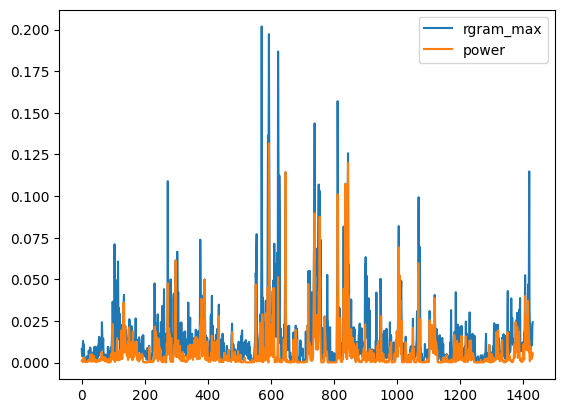

In [75]:
# rgram_max 和 power 画图
plt.plot(rgram_max)
plt.plot(power)
plt.legend(["rgram_max", "power"])

第 99 列按照时延定位的功率为： 0.022986254
第 99 列按照最大功率定位的功率为： 0.03651271
第 99 列按照时延定位的时延索引为： 1519
第 99 列按照最大功率定位的时延索引为： 1518


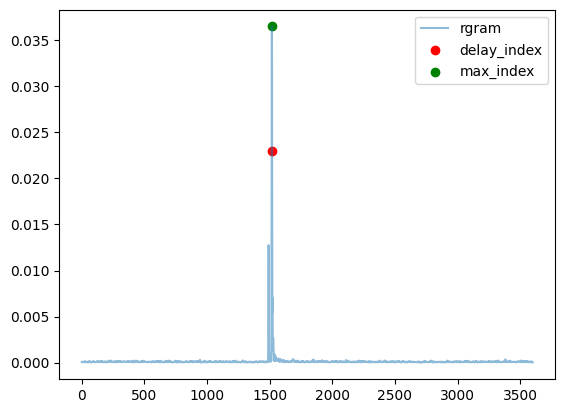

In [91]:
column_num = 98
delay_power_1 = rgram[sub_star_point_delay_index[column_num], column_num]
max_index_1 = np.argmax(rgram[:,column_num])
delay_index_1 = sub_star_point_delay_index[column_num]
max_power_1 = rgram_max[column_num]
# 打印
print("第",column_num+1,"列按照时延定位的功率为：",delay_power_1)
print("第",column_num+1,"列按照最大功率定位的功率为：",max_power_1)
print("第",column_num+1,"列按照时延定位的时延索引为：",delay_index_1)
print("第",column_num+1,"列按照最大功率定位的时延索引为：",max_index_1)
# rgram第二列画图，scatter位于上层
plt.plot(rgram[:,column_num],alpha=0.5)
plt.scatter(delay_index_1,delay_power_1,c="red",alpha=1)
plt.scatter(max_index_1,max_power_1,c="green",alpha=1)
plt.legend(["rgram","delay_index","max_index"])

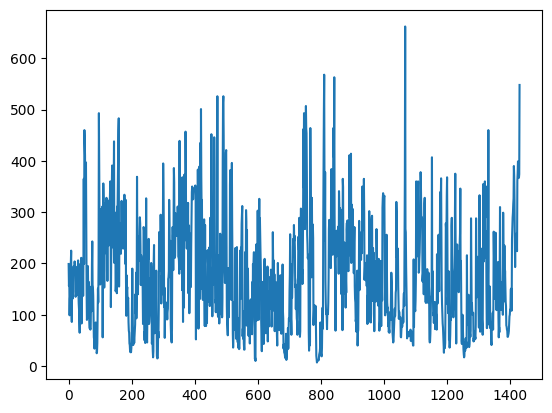

In [77]:
# 对于delay_index，delay_index[i,:]等于sub_star_point_delay_index[i]的为true，否则为false
mask = delay_index == sub_star_point_delay_index[:, np.newaxis]
# 存储每个维度mask为true的个数
mask_sum = np.sum(mask, axis=1)
# 画图
plt.plot(mask_sum)

In [78]:
# 根据mask提取相同维度的area和incident_angle,true的为原值，false的为np.nan
sub_star_point_area = np.where(mask, area, np.nan)
sub_star_point_incident_angle = np.where(mask, incident_angle, np.nan)
sub_star_point_area.shape

(1432, 12000)

count    1.432000e+03
mean     5.335532e+05
std      3.177056e+05
min      2.100967e+04
25%      2.822094e+05
50%      4.758903e+05
75%      7.415224e+05
max      1.987966e+06
dtype: float64

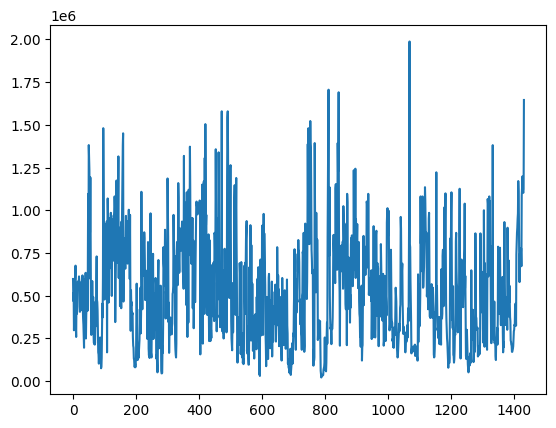

In [79]:
sub_star_point_area_sum = np.zeros(sub_star_point_area.shape[0])
for i in range(sub_star_point_area.shape[0]):
    # 去除nan值
    temp_incident_angle = sub_star_point_incident_angle[i][~np.isnan(sub_star_point_incident_angle[i])]
    temp_area = sub_star_point_area[i][~np.isnan(sub_star_point_area[i])]
    # 计算面积之和
    sub_star_point_area_sum[i] = np.sum(temp_area * np.cos(temp_incident_angle))
# 画图
plt.plot(sub_star_point_area_sum)
# describe sub_star_point_area_sum
pd.Series(sub_star_point_area_sum).describe()

In [80]:
print(_distance.shape)
print(power.shape)
print(sub_star_point_area_sum.shape)

(1432,)
(1432,)
(1432,)


In [93]:
# 画图
def process_img_for_plot(img):
    # log处理
    imgScale = np.log10(img + 1e-30)
    # 获取实际的值
    imgValid = imgScale[img != 0]
    # 使图像分布在0-255
    p10 = np.percentile(imgValid, 10)
    m = 255 / (imgValid.max() - p10)
    b = -p10 * m
    # 去除最小值
    img = imgScale * m + b
    img[img < 0] = 0
    return img
img = process_img_for_plot(rgram)
# power的值改为从img获取
power = img[sub_star_point_delay_index,np.arange(rgram.shape[1])]

In [94]:
# 以第几个点为基准
point_num = 1
power_base = power[point_num]
# 假设第一个点的介电常数为3
epsilon_base = 3
# 根据sqrt(epsilon) = (1+abs(r)) / (1-abs(r))计算反射系数
r_base = (np.sqrt(epsilon_base) - 1) / (np.sqrt(epsilon_base) + 1)
H_base = _distance[point_num]
area_base = sub_star_point_area_sum[point_num]

In [95]:
r_point = np.sqrt(power/ power_base * area_base / (H_base ** 2) * (r_base ** 2) / sub_star_point_area_sum * (_distance ** 2))
epsilon_point = ((1 + abs(r_point)) / (1 - abs(r_point))) ** 2

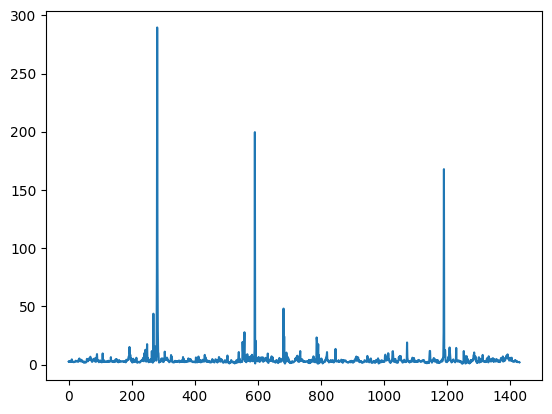

In [96]:
# 画图
import matplotlib.pyplot as plt
plt.plot(epsilon_point)
plt.savefig("epsilon_point1.png",dpi=300)

In [97]:
# describe epsilon_point
pd.Series(epsilon_point).describe()

count    1432.000000
mean        4.367460
std        10.984938
min         1.000000
25%         2.442881
50%         3.022908
75%         4.140632
max       289.604639
dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x2de7b44e250>,
 'caps': [<matplotlib.lines.Line2D at 0x2de7b44e7f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2de7b441f40>],
 'medians': [<matplotlib.lines.Line2D at 0x2de7b44ed90>],
 'fliers': [],
 'means': []}

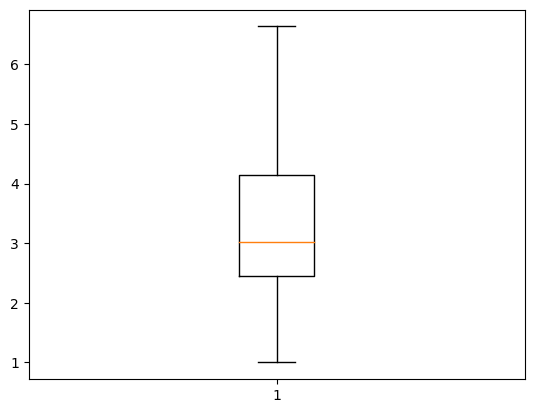

In [98]:
# 画箱图，不显示异常值
plt.boxplot(epsilon_point,showfliers=False)

0.9846368715083799


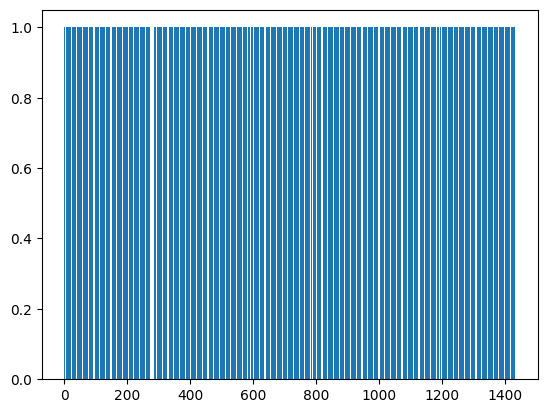

In [99]:
# epsilon_point在0-10之间的置1，否则置0
epsilon_point_binary = np.where((epsilon_point > 0) & (epsilon_point < 15),1,0)
# 画柱状图
plt.bar(np.arange(len(epsilon_point_binary)),epsilon_point_binary)
# print 1的占比
print(np.sum(epsilon_point_binary)/len(epsilon_point_binary))

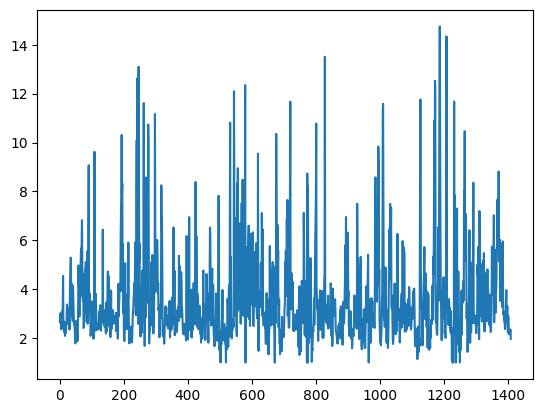

In [100]:
# 画出epsilon_point在0-10之间的值
plt.plot(epsilon_point[epsilon_point_binary==1])

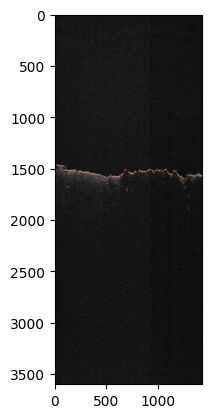

In [101]:
# 画图
def process_img_for_plot(img):
    # log处理
    imgScale = np.log10(img + 1e-30)
    # 获取实际的值
    imgValid = imgScale[img != 0]
    # 使图像分布在0-255
    p10 = np.percentile(imgValid, 10)
    m = 255 / (imgValid.max() - p10)
    b = -p10 * m
    # 去除最小值
    img = imgScale * m + b
    img[img < 0] = 0
    return img
plt.imshow(process_img_for_plot(rgram),cmap="gray")
# 点的大小1像素,透明度0.9,颜色红色,形状点
plt.scatter(np.arange(len(sub_star_point_delay_index)),sub_star_point_delay_index,c="red",alpha=0.01,marker=".",s=1)
plt.savefig("rgram_with_point.png",dpi=300)